Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached transformers-4.35.0-py3-none-any.whl.metadata (123 kB)
  Using cached huggingface_hub-0.36.2-py3-none-any.whl.metadata (15 kB)
  Using cached tokenizers-0.14.1.tar.gz (317 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [24 lines of output]
  Python reports SOABI: cp313-win_amd64
  Computed rustc target triple: x86_64-pc-windows-msvc
  Installation directory: C:\Users\pc\AppData\Local\puccinialin\puccinialin\Cache
  Rustup already downloaded
  Installing rust to C:\Users\pc\AppData\Local\puccinialin\puccinialin\Cache\rustup
  warn: It looks like you have an existing rustup settings file at:
  warn: C:\Users\pc\.rustup\settings.toml
  warn: Rustup will install the default toolchain as specified in the settings file,
  warn: instead of the one inferred from the default host triple.
  warn: installing msvc toolchain without its prerequisites
  info: profile set to 'minimal'
  info: default host triple is x86_64-pc-windows-msvc
  warn: Updating existing toolchain, profile choice will be ignored
  info: syncing channel updates for 'stable-x86_64-pc-windows-msvc'
  info: default toolc

Reports generated and saved to 'task2_output/generated_reports.csv'.


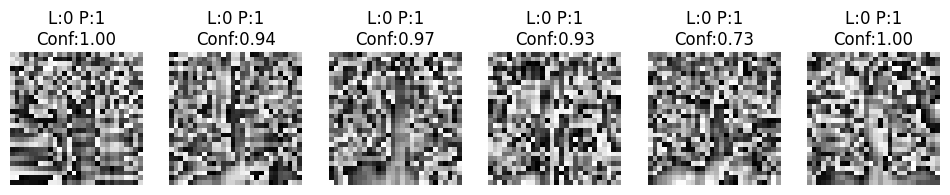

Image 0: Label=0, CNN Pred=1, CNN Prob=1.00
Report:
this chest x - ray has a predicted pneumonia probability of 1. 00. generate a structured radiology report with findings and impression.
--------------------------------------------------------------------------------
Image 1: Label=0, CNN Pred=1, CNN Prob=0.94
Report:
this chest x - ray has a predicted pneumonia probability of 0. 94. generate a structured radiology report with findings and impression.
--------------------------------------------------------------------------------
Image 2: Label=0, CNN Pred=1, CNN Prob=0.97
Report:
this chest x - ray has a predicted pneumonia probability of 0. 97. generate a structured radiology report with findings and impression.
--------------------------------------------------------------------------------
Image 3: Label=0, CNN Pred=1, CNN Prob=0.93
Report:
this chest x - ray has a predicted pneumonia probability of 0. 93. generate a structured radiology report with findings and impression.
-----

In [6]:

# ==============================
# TASK 2: Medical Report Generation (Python 3.11 environment)
# ==============================

import sys
# Install CPU-only PyTorch + transformers in this notebook's environment
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install transformers==4.35.0
!{sys.executable} -m pip install pillow matplotlib pandas


# 0️⃣ Install compatible transformers and dependencies in this environment
!pip install torch torchvision transformers==4.35.0 pillow matplotlib pandas

# 1️⃣ Imports
import torch
import pandas as pd
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import os

device = "cpu"  # No GPU available

# 2️⃣ Load BLIP model (CPU-safe)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
vlm_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

# 3️⃣ Load Task 1 outputs
task1_dir = "task1_output"  # Shared folder or copy from Task 1 environment

test_predictions = pd.read_csv(os.path.join(task1_dir, "test_predictions.csv"))
misclassified_data = np.load(os.path.join(task1_dir, "misclassified_images.npz"))

# Load misclassified images for report generation
mis_images = misclassified_data["images"]  # shape: (N, 28,28)
mis_labels = misclassified_data["labels"]
mis_preds = misclassified_data["preds"]
mis_probs = misclassified_data["probs"]

# Convert misclassified images to PIL for BLIP
mis_pil_images = [Image.fromarray((img.squeeze()*255).astype(np.uint8)) for img in mis_images]

# 4️⃣ Generate reports for selected images
generated_reports = []

for idx, pil_img in enumerate(mis_pil_images):
    cnn_prob = mis_probs[idx]

    # CNN-conditioned prompt
    prompt = f"This chest X-ray has a predicted pneumonia probability of {cnn_prob:.2f}. Generate a structured radiology report with Findings and Impression."

    # Process image
    inputs = processor(images=pil_img, text=prompt, return_tensors="pt").to(device)

    # Generate report
    output_ids = vlm_model.generate(**inputs, max_length=200)
    report_text = processor.decode(output_ids[0], skip_special_tokens=True)

    generated_reports.append({
        "image_index": idx,
        "label": mis_labels[idx],
        "cnn_pred": mis_preds[idx],
        "cnn_prob": cnn_prob,
        "report": report_text
    })

# Save CSV
os.makedirs("task2_output", exist_ok=True)
df_reports = pd.DataFrame(generated_reports)
df_reports.to_csv("task2_output/generated_reports.csv", index=False)
print("Reports generated and saved to 'task2_output/generated_reports.csv'.")

# 5️⃣ Display sample
plt.figure(figsize=(12,4))
num_to_show = min(6, len(mis_pil_images))
for i in range(num_to_show):
    plt.subplot(1,num_to_show,i+1)
    plt.imshow(mis_pil_images[i], cmap="gray")
    plt.title(f"L:{mis_labels[i]} P:{mis_preds[i]}\nConf:{mis_probs[i]:.2f}")
    plt.axis("off")
plt.show()

# Print first 5 reports
for i, row in df_reports.head(5).iterrows():
    print(f"Image {row['image_index']}: Label={row['label']}, CNN Pred={row['cnn_pred']}, CNN Prob={row['cnn_prob']:.2f}")
    print("Report:")
    print(row['report'])
    print("-"*80)